### Managing Imports

In [2]:
from PIL import Image, ImageOps
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

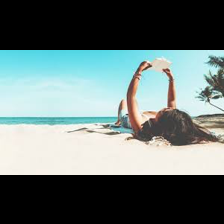

In [29]:
#loading image

data = Image.open("../input/Image Captions/Train/Images/image_00010.jpg")
data.size

resized_image = ImageOps.pad(data, (224,224))
resized_image.size
resized_image

### Custom Dataset Loaders

In [3]:
#Tokenizer to split sentences into a list of words
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary():
  """
  Class to convert the captions to index sequential tensors
  """

  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} #index to sentence
    self.stoi = {"<PAD>": 0, "<SOS>":1, "<EOS>": 2, "<UNK>":3} #sentence to index
    self.freq_threshold = freq_threshold #threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] #convert sentence to words

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): #convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: #once more than freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) #convert annnotations to labels by converting each word to the index inside the vocab, else UNK tag
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]

In [4]:
class padAnnotations():
  """
  Collate function to pad all caption to the same length as max(len(caption)) in a batch
  """
  def __init__(self, pad_idx, batch_first = False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch] 
    imgs = torch.cat(imgs, dim=0)
    labels = [item[1] for item in batch]
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=self.batch_first, padding_value=self.pad_idx)

    return imgs, labels

In [61]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None, freq_threshold=2):
        """
        Args:
            Note: the order of the csv_file and root_dir are related, csv_file[0] contains captions for images in root_dir[0]
            csv_file (list): Lists of path to CSV files with annotations.
            root_dir (list): List of directory containing images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        #merging annotations into 1 dataset
        self.annotations = pd.DataFrame()
        self.root_dir_boundary = []
        for idx, label_files in enumerate(csv_file):                
            labels = pd.read_csv(label_files, index_col=0)
            self.annotations = pd.concat([self.annotations, labels], ignore_index=True)

            #getting the image boundary on which idx belongs to which image file path
            if idx == 0: 
                self.root_dir_boundary.append(len(labels))
            else:
                #get the number of images in root directory and append with the previous to get the range of index that are in this filepath
                self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        #initialise vocabulary
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list())
        
    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.annotations.iloc[idx, 0] #Image name as column 0
        #finding the correct root directory filepath in the list does the image belong to
        image_dir_idx = 0
        while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
            image_dir_idx += 1

        img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"

        image = Image.open(img_path)
        image = ImageOps.pad(image, self.img_size) #resize image
        annotation = self.annotations.iloc[idx, 1] #Annotation as column 1
        
        #converting caption to index tensor
        numercalized_annotations = [self.vocab.stoi["<SOS>"]]
        numercalized_annotations += self.vocab.numericalize(annotation)
        numercalized_annotations.append(self.vocab.stoi["<EOS>"])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(numercalized_annotations)


In [69]:
image_size = (256,256)

# Define transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
dataset = CustomDataset(csv_file=['../input/Landscape/Train/Labels/Blip_Label.csv', '../input/Flicker8k/Train/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Train/Images', '../input/Flicker8k/Train/Images'],
                        transform=transform,
                        img_size=image_size)

# Create a PyTorch DataLoader
dataloader_batchfirst = DataLoader(dataset,
                        batch_size=64,
                        shuffle=True,
                        collate_fn = padAnnotations(pad_idx = dataset.vocab.stoi["<PAD>"], batch_first=True))

dataloader = DataLoader(dataset,
                        batch_size=64,
                        shuffle=True,
                        collate_fn = padAnnotations(pad_idx = dataset.vocab.stoi["<PAD>"]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([23, 64])
tensor([   1,   16,   17,  561, 1398,    7,    4, 1207,  576,   31,    4,  156,
        1425,   17,  152,   31,  126,   15,  568, 1193,    2,    0,    0])
['<SOS>', 'woman', 'is', 'blowing', 'bubbles', 'and', 'a', 'little', 'girl', 'in', 'a', 'pink', 'outfit', 'is', 'playing', 'in', 'front', 'of', 'her', '.', '<EOS>', '<PAD>', '<PAD>']


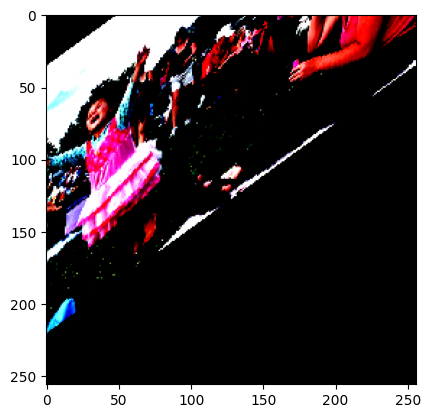

In [71]:
train_features, train_labels = next(iter(dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze() #removing the batch
img = np.transpose(img.numpy(), (1, 2, 0)) #for matplotlib to (299, 299, 3) where channel is last
plt.imshow(img)

#transpose as not batch_first means we get the first word of every batch instead of sentence per batch
label = train_labels.T[0] 
print(label)
print([dataset.vocab.itos[idx] for idx in label.tolist()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64, 36])
tensor([  1,   4, 116,  52,  75,   9,  29,   5,  61,   7,  61,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])
['<SOS>', 'a', 'purple', 'sunset', 'over', 'the', 'ocean', 'with', 'rocks', 'and', 'rocks', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


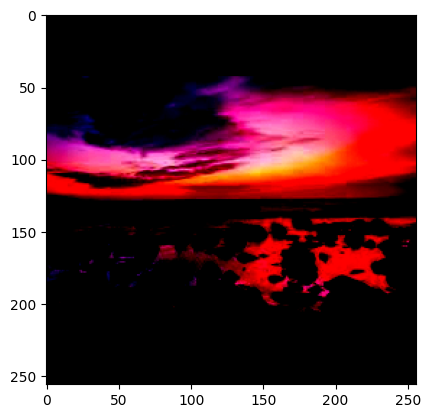

In [72]:
# exact same but we did batch first, so no need to transpose
train_features, train_labels = next(iter(dataloader_batchfirst))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = np.transpose(img.numpy(), (1, 2, 0))
plt.imshow(img)

label = train_labels[0] #no need transpose
print(label)
print([dataset.vocab.itos[idx] for idx in label.tolist()])

### Evaluation Metrics function

In [83]:
from nltk.translate.bleu_score import sentence_bleu

def get_bleu_score(predicted:str, references:list):
    for idx, sentence in enumerate(references):
        references[idx] = sentence.split()

    predicted = predicted.split()

    BLEU1 = sentence_bleu(references, predicted, weights=(1, 0, 0, 0))
    BLEU2 = sentence_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU3 = sentence_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU4 = sentence_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU1": BLEU1, "BLEU2": BLEU2, "BLEU3": BLEU3, "BLEU4": BLEU4}

In [94]:
import evaluate

def get_rouge_score(predicted:str, references:list):

    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=[predicted], references=[references])
    return results

In [96]:
reference = [
    'this is a dog',
    'it is dog',
    'dog it is',
    'a dog, it is'
]
candidate = 'it is a dog'

print(get_bleu_score(candidate, reference))
print(get_rouge_score(candidate, reference))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'BLEU1': 1.0, 'BLEU2': 1.0, 'BLEU3': 0.7955364837549187, 'BLEU4': 1.0270193092081295e-77}
{'rouge1': 1.0, 'rouge2': 0.6666666666666666, 'rougeL': 0.8571428571428571, 'rougeLsum': 0.8571428571428571}


### Architecture - InceptionV3 + LSTM

### Architecture - ResNet50 + Attention + LSTM

### Architecture

In [41]:
import torchvision.models as models

class EncoderCNN(torch.nn.Module):
    def __init__(self, trainable=False):
        super(EncoderCNN, self).__init__()
        self.trainable = trainable
        self.inception = models.inception_v3(pretrained=True)
        self.inception.aux_logits=False
        
        removed = list(self.inception.children())[:-3]
        self.inception = torch.nn.Sequential(*removed)

    def forward(self, image):
        features = self.inception(image)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)

        for name, param in self.inception.named_parameters(): #prevent any training
            param.requires_grad = self.trainable

        return features

In [42]:
class AttentionBlock(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_dim=1):
        super(AttentionBlock, self).__init__()

        self.W_a = torch.nn.Linear(feature_size, hidden_size) # fully-connected layer to learn first weight matrix Wa
        self.U_a = torch.nn.Linear(hidden_size, hidden_size) # fully-connected layer to learn the second weight matrix Ua
        self.v_a = torch.nn.Linear(hidden_size, output_dim) # fully-connected layer to produce score (output), learning weight matrix va

    def forward(self, features, hidden_state): #hidden state decoder hiden state
        
        decoder_hidden = hidden_state.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        # apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = torch.functional.softmax(atten_score, dim = 1)
        # first, we will multiply each vector by its softmax score
        # next, we will sum up this vectors, producing the attention context vector
        # the size of context equals to a number of feature maps
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)

        return context, atten_weight

In [43]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        """
        feature_size = size of the image features
        embed_size = size of caption embeddings
        hidden_size = hidden state size for lstm
        """
        self.embeddings = torch.nn.Embedding(vocab_size, embed_size)
        self.attention = AttentionBlock(feature_size, hidden_size)
        self.lstm = torch.nn.LSTM(embed_size+feature_size, hidden_size, num_layers)
        self.fc =  torch.nn.Linear(hidden_size, vocab_size)
        self.dropout = torch.nn.Dropout(0.5)
        
        self.init_h = torch.nn.Linear(feature_size, hidden_size)
        self.init_c = torch.nn.Linear(feature_size, hidden_size)

        self.sample_temp = 0.5  # scale the inputs to softmax

    
    def init_hidden(self, features):
        """
        Initializes hidden state and cell memory using average feature vector.
        Args:
            features: features returned from Encoder
        Retuns:
            h0: initial hidden state (short-term memory)
            c0: initial cell state (long-term memory)
        """
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    
    def forward(self, features, captions, device, sample_prob=0.5):
        caption_embeddings = self.embeddings(captions)  # create embeddings for captions of size (batch, sqe_len, embed_dim)
        h,c = self.init_hidden(features)
        
        seq_len = captions.size(1)
        feature_dim = features.size(1)
        batch_size = features.size(0)

        # these tensors will store the outputs from lstm cell and attention weights
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_dim).to(device)

        for t in range(seq_len):
            sampleprob = 0.0 if t == 0 else sample_prob #will never use scheduled sampling for first word
            use_sampling = np.random.random() < sampleprob

            #do not sample, use the actual output from caption
            if use_sampling == False:
                word_embed = caption_embeddings[:,t,:]

            context, atten_weight = self.attention(features, h)

            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.dropout(h)
            output = self.fc(h)
            
            #sample, use the best predicted value as the token instead of the actual token in the caption
            if use_sampling == True:
                # use sampling temperature to amplify the values before applying softmax
                scaled_output = output / self.sample_temp
                scoring = torch.functional.log_softmax(scaled_output, dim=1)
                top_idx = scoring.topk(1)[1]
                word_embed = self.embeddings(top_idx).squeeze(1) 
            
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
        
        return outputs, atten_weights

In [46]:
class CNNtoRNN(torch.nn.Module):
  def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_layers):
    super(CNNtoRNN, self).__init__()
    self.encoderCNN = EncoderCNN()
    self.decoderRNN = DecoderRNN(feature_size, embed_size, hidden_size, vocab_size, num_layers)

  #for training with a caption
  def forward(self, images, captions, device):
    features = self.encoderCNN(images)
    outputs = self.decoderRNN(features, captions, device)
    return outputs

  #for prediction where there is a semi caption and they have to continue the caption
  def caption_image(self, image, vocabulary, device, max_length=50):
     
    result_caption = []
    alphas = []

    with torch.no_grad(): #no training
      x = self.encoderCNN(image) 
      input_word = torch.tensor(0).unsqueeze(0).to(device)
      h, c = self.decoderRNN.init_hidden(x)

      for _ in range(max_length):

        embedded_word = self.decoderRNN.embeddings(input_word)
        context, atten_weight = self.decoderRNN.attention(x, h)
        input_concat = torch.cat([embedded_word, context],  dim = 1)
        h, c = self.decoderRNN.lstm(input_concat, (h,c))
        h = self.decoderRNN.dropout(h)
        output = self.decoderRNN.fc(h)     
        
        scoring = torch.nn.functional.log_softmax(output, dim=1)
        predicted = scoring[0].topk(1)[1] #first word

        result_caption.append(predicted.item())
        alphas.append(atten_weight)

        input_word = predicted
          
        if vocabulary.itos[predicted.item()] == "<EOS>":
          break
      
      return [vocabulary.itos[idx] for idx in result_caption]  #get the string from the vocabulary instead of the indices


In [39]:
model = models.inception_v3(pretrained=True)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [47]:
batch_size = 64          # batch size, change to 64
embed_size = 256         # dimensionality of image and word embeddings
hidden_size = 512        # number of features in hidden state of the RNN decoder
feature_size = 2048      # number of feature maps, produced by Encoder
num_epochs = 1        # number of training epochs
num_layers = 3
vocab_size = len(dataset.vocab)
learning_rate = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
model = CNNtoRNN(feature_size, embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  total_loss = 0
  avg_loss = 0
  for idx, (imgs, annotations) in enumerate(dataloader):
    imgs = imgs.to(device)
    annotations = annotations.to(device)

    outputs = model(imgs, annotations[:-1], device) #training model to guess the last word
    #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
    loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape the output
    optimizer.zero_grad()
    loss.backward(loss)
    optimizer.step()

    total_loss += loss.item()
    avg_loss = total_loss/(idx+1)

  print(f"Epoch {epoch} completed, total loss: {total_loss}, avg loss per batch: {avg_loss}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: cannot assign module before Module.__init__() call